In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages

from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case
from icedef import statoil_arcticnet_data as sd

reload(drift)
reload(metocean)
reload(simulator)
reload(plot)
reload(iceberg)
reload(test_case)
reload(sd)

<module 'icedef.statoil_arcticnet_data' from '/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py'>

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# 20180928

# Read in Beacon Data 

In [3]:
df = sd.get_df(sd.dir_path + sd.csv_filenames[1])
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,50519,Solara,2015-04-23 18:48:37,NaN,49.22403,-51.25820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50519,Solara,2015-04-23 18:49:07,NaN,49.22401,-51.25817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50519,Solara,2015-04-23 18:49:34,NaN,49.22400,-51.25809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50519,Solara,2015-04-23 18:49:59,NaN,49.22403,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50519,Solara,2015-04-23 18:50:26,NaN,49.22399,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Simulation

In [4]:
tc = test_case.TestCase()

In [10]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

Ca, Cw = 3, 0.1
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results1 = sim.run_simulation(store_results_as=label, **run_sim_kwargs)

Ca, Cw = 0.1, 5
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results2 = sim.run_simulation(store_results_as=label, **run_sim_kwargs)

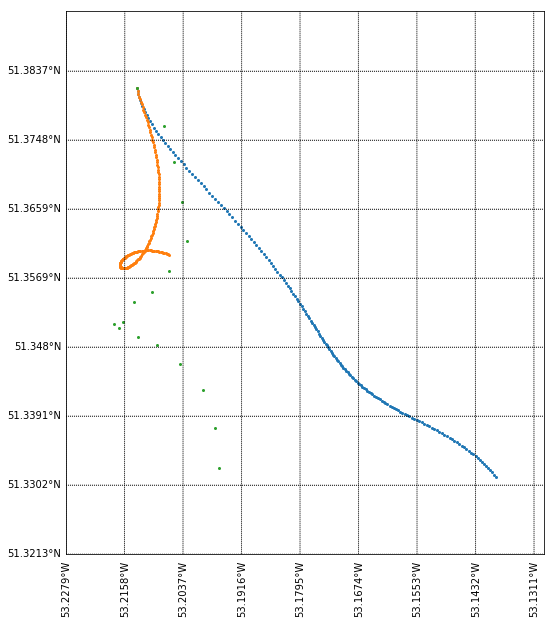

In [11]:
plot.plot_track([results1['latitude'].values, results1['longitude'].values],
                [results2['latitude'].values, results2['longitude'].values],
                [tc.ref_lats.values, tc.ref_lons.values], s=4
)                

# Optimization

In [12]:
keys = ['Ca', 'Cw']
x0 = [1, 1]
bounds = [[1, 10], [1,10]]
reference_vectors = [tc.ref_lats, tc.ref_lons]

sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

KeyboardInterrupt: 

In [53]:
optimization_result

      fun: 0.0031432591383775983
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.31836466e-07, -1.30742162e-04])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 12
   status: 0
  success: True
        x: array([ 5.64192995, 10.        ])

## Simulation with Optimization Result

In [13]:
Ca, Cw = optimization_result.x

run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results = sim.run_simulation(**run_sim_kwargs)

NameError: name 'optimization_result' is not defined

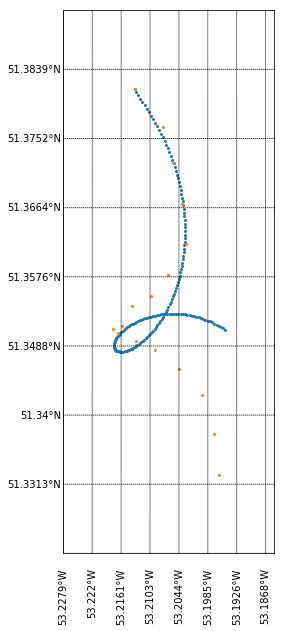

In [59]:
plot.plot_track(
    [results['latitude'].values, results['longitude'].values], 
    [ref_lats.values, ref_lons.values], pads=[0.01]*4,
    s=4
)

# Surface Optimization

In [19]:
Ca_num = 3
Cw_num = 3
Ca_lower_bound = 1; Ca_upper_bound = 5
Cw_lower_bound = 5; Cw_upper_bound = 16

scaling = 'lin'

if scaling == 'log':

    Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
    Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

elif scaling == 'lin':
    
    Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
    Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

In [20]:
mse_matrix = np.zeros((Ca_num, Cw_num))
keys = ['Ca', 'Cw']
reference_vectors = [tc.ref_lats, tc.ref_lons]

for i in range(Ca_num):
    for j in range(Cw_num):
        form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
        mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560

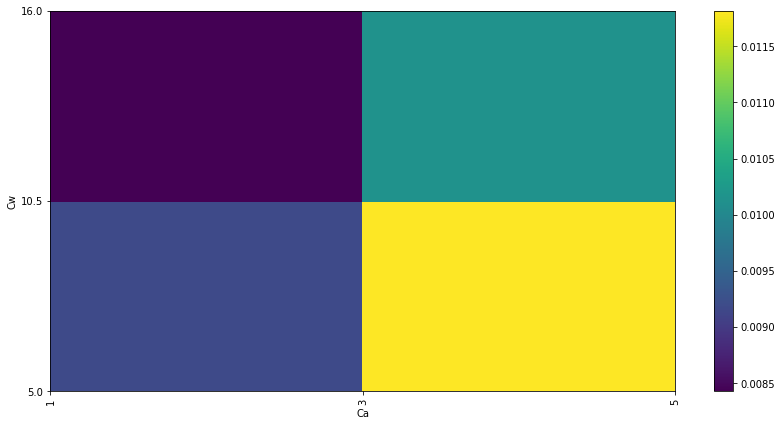

In [21]:
fig = plt.figure(figsize=(14,7))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix)#, vmin=0.02525, vmax=0.02675)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.colorbar()

plt.show()

# 20181011

# Ekman

In [78]:
# No Ekman
ekman = False
kwargs = {'ekman': ekman}
xds = sim.run_simulation(store_results_as='no_ekman', **kwargs)

# Ekman to depth of 100 m
ekman = True
kwargs = {'ekman': ekman}
xds = sim.run_simulation(store_results_as='ekman_100', **kwargs)

# Ekman to depth of 1000 m
ekman = True
depth_vec = np.arange(0, -1100, -100)
kwargs = {'ekman': ekman, 'depth_vec': depth_vec}
xds = sim.run_simulation(store_results_as='ekman_1000', **kwargs)

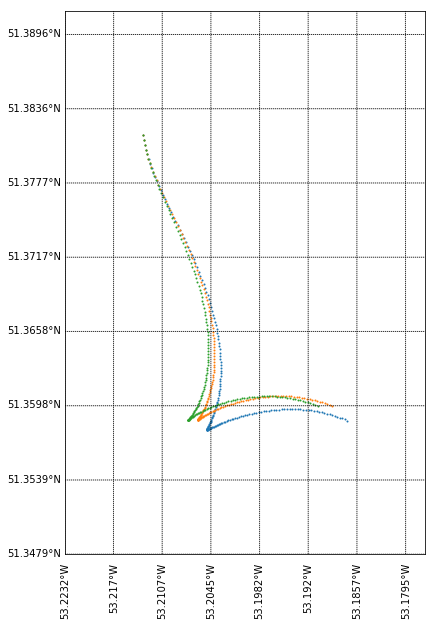

In [79]:
plot.plot_track([sim.results['no_ekman']['latitude'].values, sim.results['no_ekman']['longitude'].values], 
                [sim.results['ekman_100']['latitude'].values, sim.results['ekman_100']['longitude'].values], 
                [sim.results['ekman_1000']['latitude'].values, sim.results['ekman_1000']['longitude'].values],
               pads=[0.01]*4)

# Testing Drift Model with Constant Metocean Fields

In [188]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

## Default

In [189]:
label = 'default'
xds = sim.run_simulation(store_results_as=label)

In [190]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

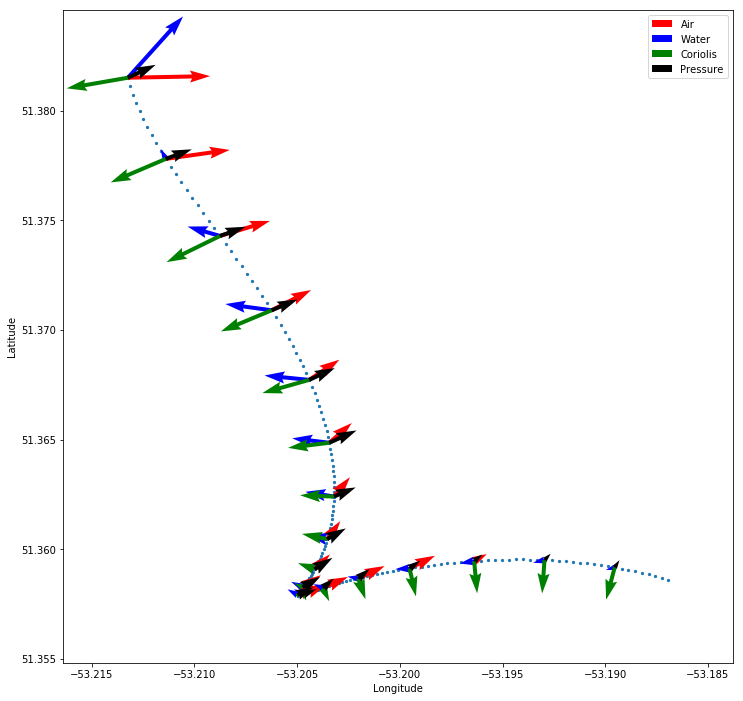

In [191]:
arrow_colors = ['red', 'blue', 'green', 'black']
arrow_labels = ['Air', 'Water', 'Coriolis', 'Pressure']

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

arrow_scale = 1e6
autoscale_figure = False
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale}

plot.plot_iceberg_track(sim.results[label]['latitude'].values, sim.results[label]['longitude'].values, **kwargs)

## No Current, Constant Wind

In [200]:
label = 'no_current_constant_wind'
sim.start_velocity = 0, 0
sim.set_constant_currents((0, 0))
sim.set_constant_winds((10, 0))
xds = sim.run_simulation(store_results_as=label)

In [201]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

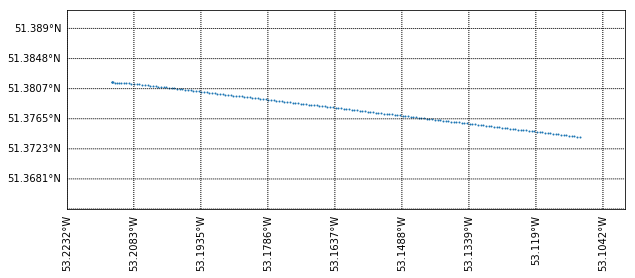

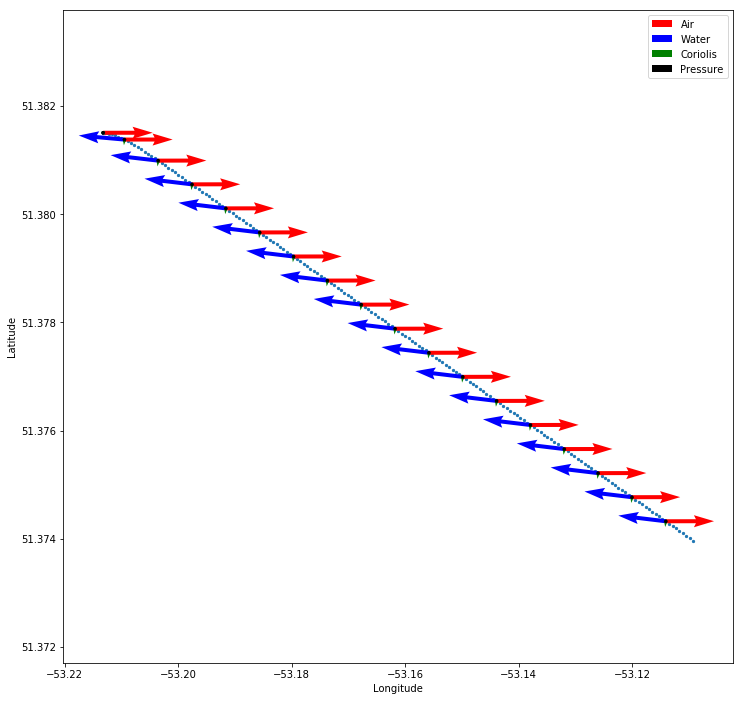

In [202]:
arrow_scale = 1e7
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale}

sim.plot_track([label])
plot.plot_iceberg_track(sim.results[label]['latitude'].values, sim.results[label]['longitude'].values, **kwargs)

## No Wind, Constant Current

In [203]:
label = 'no_wind_constant_current'
sim.start_velocity = 0, 0
sim.set_constant_currents((0.1, 0))
sim.set_constant_winds((0, 0))
xds = sim.run_simulation(store_results_as=label)

In [204]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

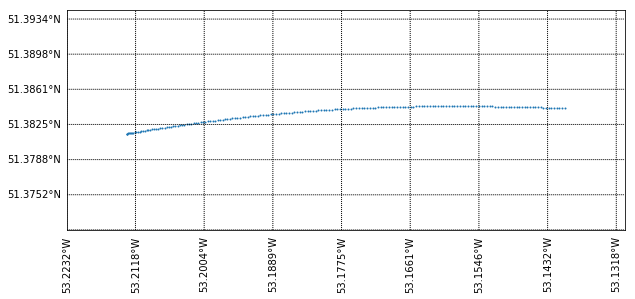

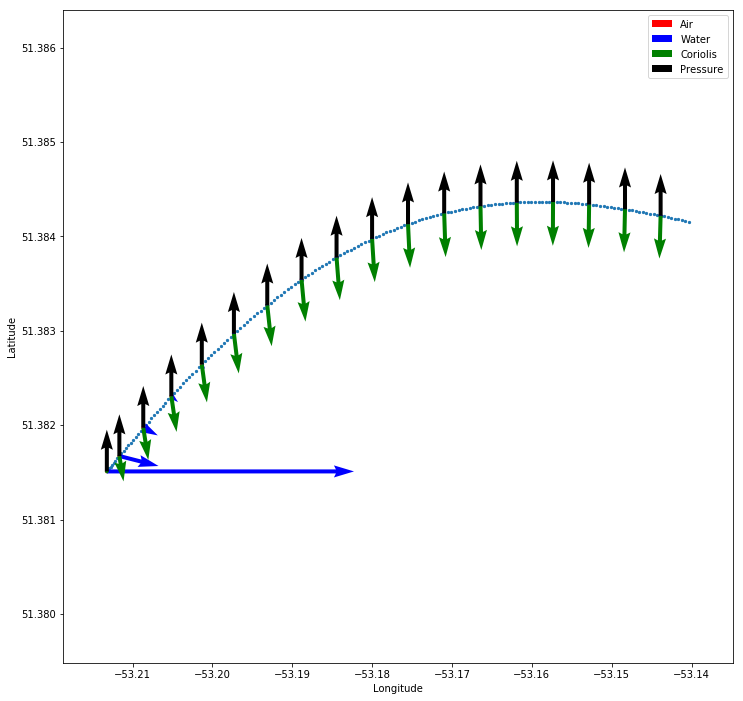

In [207]:
arrow_scale = 1e6
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels,  
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale}

sim.plot_track([label])
plot.plot_iceberg_track(sim.results[label]['latitude'].values, sim.results[label]['longitude'].values, **kwargs)

## No Wind or Current

In [210]:
label = 'no_wind_or_current'
sim.start_velocity = tc.start_velocity
sim.set_constant_currents((0, 0))
sim.set_constant_winds((0, 0))
xds = sim.run_simulation(store_results_as=label)

In [211]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

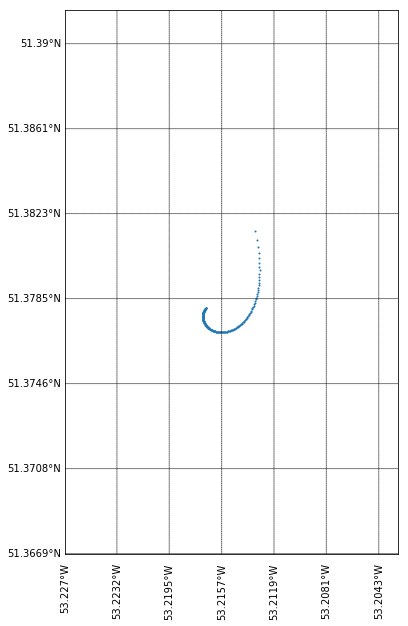

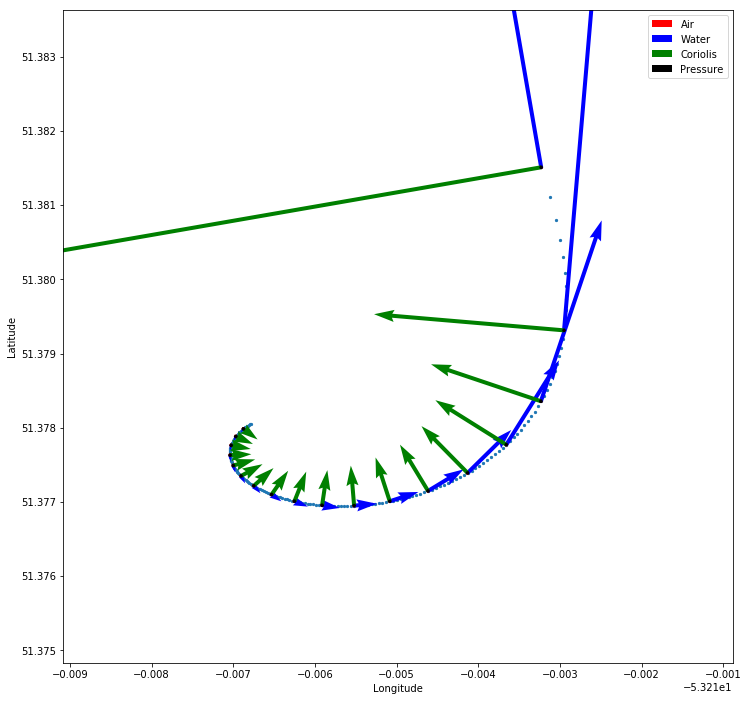

In [215]:
arrow_scale = 1e5
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale}

sim.plot_track([label])
plot.plot_iceberg_track(sim.results[label]['latitude'].values, sim.results[label]['longitude'].values, **kwargs)

## Constant Current and Wind

In [223]:
label = 'constant_current_and_wind'
sim.start_velocity = 0, 0
sim.set_constant_currents((0.1, 0))
sim.set_constant_winds((10, 0))
xds = sim.run_simulation(store_results_as=label)

In [224]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

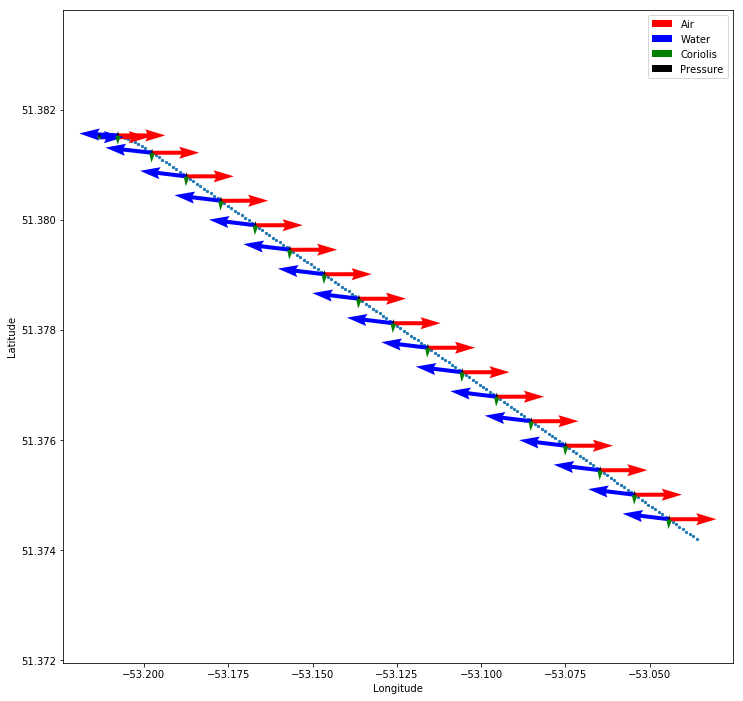

In [225]:
arrow_scale = 1e7
autoscale_figure = False
vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale}

plot.plot_iceberg_track(sim.results[label]['latitude'].values, sim.results[label]['longitude'].values, **kwargs)

# Varying Berg Size

In [183]:
reload(iceberg)
reload(simulator)

<module 'icedef.simulator' from '/home/evankielley/IceDEF/icedef/simulator.py'>

In [184]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)
label = 'default'
xds = sim.run_simulation(store_results_as=label)

In [185]:
big_label = 'big_iceberg'
sim.iceberg_size = 1600, 600
sim.reload_iceberg
kwargs = {'iceberg_size': (1600, 600)}

xds = sim.run_simulation(store_results_as=big_label)#, **kwargs)

In [186]:
small_label = 'small_iceberg'
sim.iceberg_size = 160, 60
sim.reload_iceberg
kwargs = {'iceberg_size': (160, 60)}
xds = sim.run_simulation(store_results_as=small_label, **kwargs)

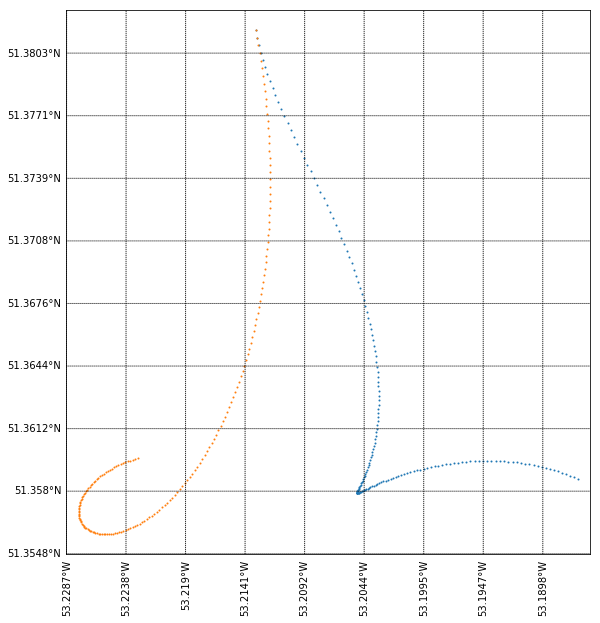

In [187]:
sim.plot_track([small_label, big_label], pads=[0.001]*4)

In [233]:
(tc.end_time - tc.start_time).astype('timedelta64[D]') / np.timedelta64(1, 'D') + 1

1.0

In [ ]:
x.
days / np.timedelta64(1, 'D')